# **ProgettoCV Test - Studenti: Daniele Francesca, Leto Marco**

In [45]:
# Import Python Standard Library dependencies
import datetime
from functools import partial
from glob import glob
import json
from copy import copy
import math
import multiprocessing
import os
from pathlib import Path
import random
import PIL.Image as PIL
from typing import Any, Dict, Optional
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import pycocotools.mask
import matplotlib.patches as patches
from PIL import Image
import cv2
from torchvision.utils import save_image

# Import utility functions
from cjm_psl_utils.core import download_file, file_extract, get_source_code
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, get_torch_device, set_seed, denorm_img_tensor, move_data_to_device
from cjm_pandas_utils.core import markdown_to_pandas, convert_to_numeric, convert_to_string
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PyTorch dependencies
import torch
from torch.amp import autocast
from torch.cuda.amp import GradScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtnt.utils import get_module_summary
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

# Import Mask R-CNN
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Import tqdm for progress bar
from tqdm.auto import tqdm

La variabile "test_dataloader è stata definita nel file "Progetto_CV_Training"

In [ ]:
# Inizializzazione del modello Mask R-CNN con backbone ResNet-50 FPN e pesi di default
model = maskrcnn_resnet50_fpn_v2(weights='DEFAULT')

# Ottenimento delle caratteristiche in ingresso per il box predictor e il mask predictor
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

# Ottenimento del numero di canali di output per il Mask Predictor
dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels


def metricheFinale():
    etichette=['mAP 50-95','mAP50','mAP75', 'mAP 50-95 S','mAP 50-95 M' , 'mAP 50-95 L','mAL 50-95','mAL 50','mAL 75', 'mAL 50-95 S','mAL 50-95 M' , 'mAL 50-95 L']

    results = []
    progress_barTest = tqdm(total=len(test_dataloader),desc="Evaluate")

    for image in test_dataloader:

        model.eval()
        output=model((image[0][0].unsqueeze(0)).to(device))

        classes = output[0]['labels']
        scores = output[0]['scores']
        boxes = output[0]['boxes']
        masks = output[0]['masks']

        boxes = boxes.view(-1, 4)
        masks = masks.view(-1, 700, 700)

        for i in range(masks.shape[0]):
            bbox=boxes[i]
            bbox = [bbox[0], bbox[1], bbox[2]-bbox[0], bbox[3]-bbox[1]]
            bbox = [round(float(x)*10)/10 for x in bbox]

            masks=masks.cpu()
            maskT=masks[i].detach().numpy()
            threshold=0.3
            maskT[maskT>threshold]=1
            maskT[maskT<=threshold]=0

            rle = pycocotools.mask.encode(np.asfortranarray(maskT.astype(np.uint8)))
            rle['counts'] = rle['counts'].decode('ascii')

            results.append({
                    'image_id': int(image[1][0]['id']),
                    'category_id': int(classes[i])-1,
                    'bbox': bbox,
                    'segmentation': rle,
                    'score': float(scores[i])
                })

        progress_barTest.update(1)

    # save file
    with open('/content/drive/MyDrive/Progetto/pred.json', 'w') as fp:
        json.dump(results, fp)

    test = '/content/drive/MyDrive/Progetto/Dataset/testset/test.json'
    gt = COCO(test)
    detections = gt.loadRes('/content/drive/MyDrive/Progetto/pred.json')

    #Si calcolano mAP e mAR sui bbox
    annType = 'bbox'
    cocoEval = COCOeval(gt, detections, annType)
    cocoEval.evaluate();
    cocoEval.accumulate();
    cocoEval.summarize();
    bBoxMetrics=cocoEval.stats
    bBoxDict = dict(zip(etichette, bBoxMetrics))

    #Si calcolano mAP e mAR sulla segmentazione
    annType = 'segm'
    cocoEval = COCOeval(gt, detections, annType)
    cocoEval.evaluate();
    cocoEval.accumulate();
    cocoEval.summarize();
    segmMetrics=cocoEval.stats
    segmDict = dict(zip(etichette, segmMetrics))

In [ ]:
model.load_state_dict(torch.load('EsecuzioneBatch16/model_best_epoche'))
metricheFinale()

In [46]:

test = 'CreazioneImmagini/Dataset/testset/test.json'
gt = COCO(test)
detections = gt.loadRes('EsecuzioneBatch16/247108_247453.json')

#Si calcolano mAP e mAR sui bbox
annType = 'bbox'
cocoEval = COCOeval(gt, detections, annType)
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

#Si calcolano mAP e mAR sulla segmentazione
annType = 'segm'
cocoEval = COCOeval(gt, detections, annType)
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()


loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.50s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.461
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.654
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.522
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.305
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.503
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.529
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

### **Analisi della Loss**


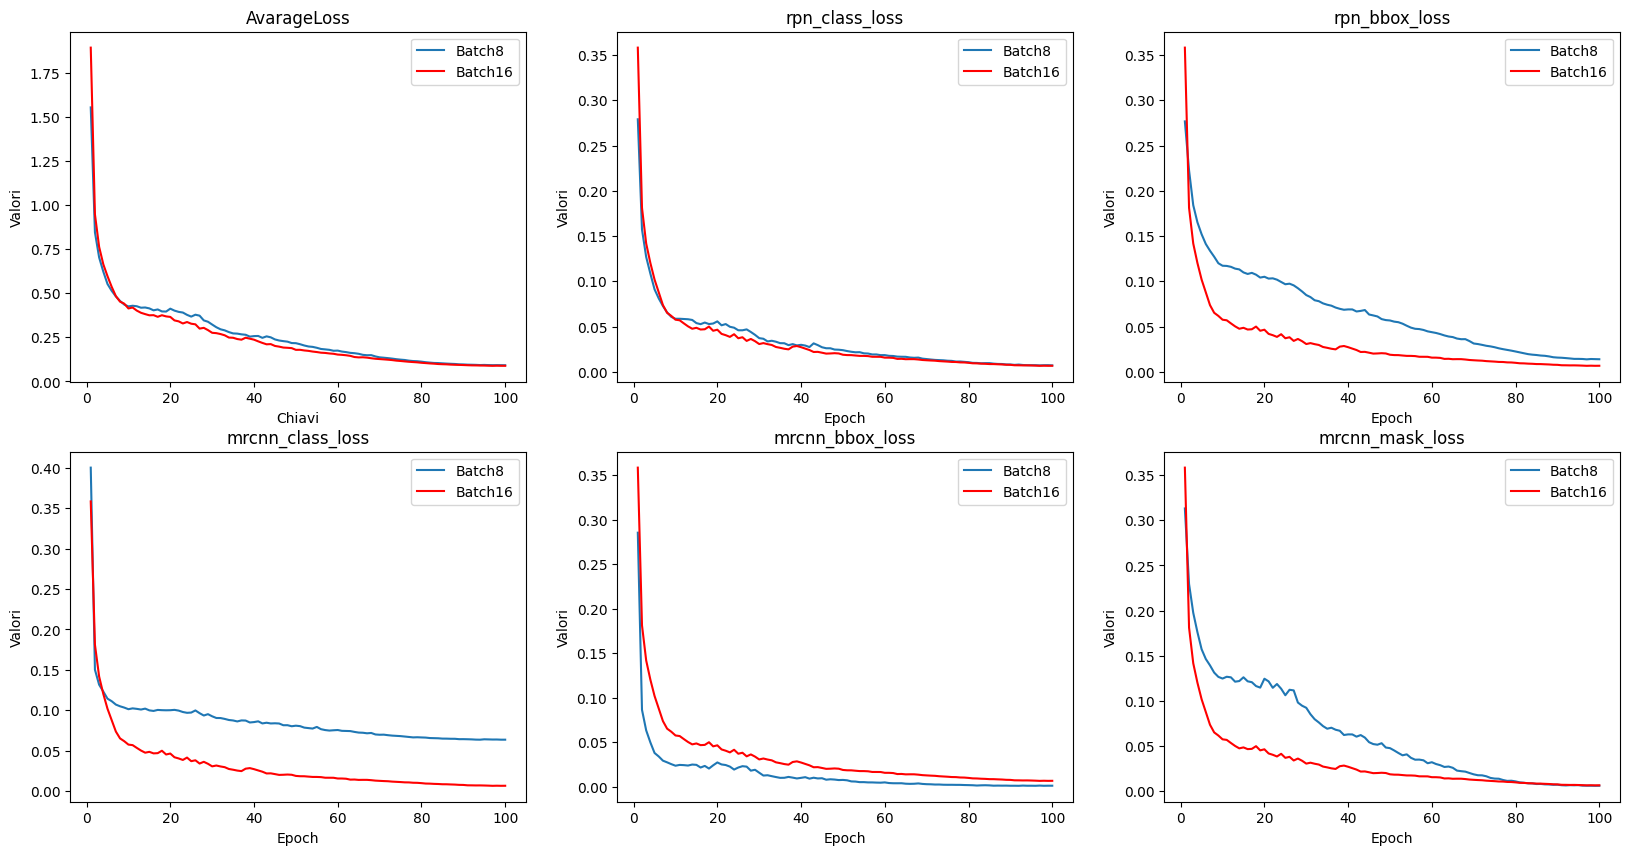

In [43]:
with open('EsecuzioneBatch8/Losses.json', 'r') as file_json:
    # Carica il contenuto del file JSON
    loss8 = json.load(file_json)

with open('EsecuzioneBatch8/AvarageLoss.json', 'r') as file_json:
    # Carica il contenuto del file JSON
    avgLoss8 = json.load(file_json)

with open('EsecuzioneBatch16/Losses.json', 'r') as file_json:
    # Carica il contenuto del file JSON
    loss16 = json.load(file_json)

with open('EsecuzioneBatch16/AvarageLoss.json', 'r') as file_json:
    # Carica il contenuto del file JSON
    avgLoss16 = json.load(file_json)

avg8=[]
rpn_class_loss8=[]
rpn_bbox_loss8=[]
mrcnn_class_loss8=[]
mrcnn_bbox_loss8=[]
mrcnn_mask_loss8=[]

avg16=[]
rpn_class_loss16=[]
rpn_bbox_loss16=[]
mrcnn_class_loss16=[]
mrcnn_bbox_loss16=[]
mrcnn_mask_loss16=[]


for i in range(len(avgLoss16)+1):
    if(i>0):
        rpn_class_loss16.append(loss16[f'{i}'][0])
        rpn_bbox_loss16.append(loss16[f'{i}'][0])
        mrcnn_class_loss16.append(loss16[f'{i}'][0])
        mrcnn_bbox_loss16.append(loss16[f'{i}'][0])
        mrcnn_mask_loss16.append(loss16[f'{i}'][0])
        avg16.append(avgLoss16[f'{i}'])


        rpn_class_loss8.append(loss8[f'{i}'][0])
        rpn_bbox_loss8.append(loss8[f'{i}'][1])
        mrcnn_class_loss8.append(loss8[f'{i}'][2])
        mrcnn_bbox_loss8.append(loss8[f'{i}'][3])
        mrcnn_mask_loss8.append(loss8[f'{i}'][4])
        avg8.append(avgLoss8[f'{i}'])


epochs= list(range(1, 101))

plt.figure(figsize=(20, 10))  # Larghezza x Altezza in pollici


plt.subplot(2, 3, 1)  # 1 riga, 2 colonne, primo grafico
plt.plot(epochs, avg8, linestyle='-',label='Batch8')
plt.plot(epochs, avg16, linestyle='-',color='red', label='Batch16')
plt.xlabel('Chiavi')
plt.ylabel('Valori')
plt.title('AvarageLoss')
plt.legend()

plt.subplot(2, 3, 2)  # 1 riga, 2 colonne, secondo grafico
plt.plot(epochs, rpn_class_loss8, linestyle='-',label='Batch8')
plt.plot(epochs, rpn_class_loss16, linestyle='-',color='red', label='Batch16')
plt.xlabel('Epoch')
plt.ylabel('Valori')
plt.title('rpn_class_loss')
plt.legend()

plt.subplot(2, 3, 3)  # 1 riga, 2 colonne, secondo grafico
plt.plot(epochs, rpn_bbox_loss8, linestyle='-',label='Batch8')
plt.plot(epochs, rpn_bbox_loss16, linestyle='-',color='red', label='Batch16')
plt.xlabel('Epoch')
plt.ylabel('Valori')
plt.title('rpn_bbox_loss')
plt.legend()

plt.subplot(2, 3, 4)  # 1 riga, 2 colonne, secondo grafico
plt.plot(epochs, mrcnn_class_loss8, linestyle='-',label='Batch8')
plt.plot(epochs, mrcnn_class_loss16, linestyle='-',color='red', label='Batch16')
plt.xlabel('Epoch')
plt.ylabel('Valori')
plt.title('mrcnn_class_loss')
plt.legend()

plt.subplot(2, 3, 5)  # 1 riga, 2 colonne, secondo grafico
plt.plot(epochs, mrcnn_bbox_loss8, linestyle='-',label='Batch8')
plt.plot(epochs, mrcnn_bbox_loss16, linestyle='-',color='red', label='Batch16')
plt.xlabel('Epoch')
plt.ylabel('Valori')
plt.title('mrcnn_bbox_loss')
plt.legend()

plt.subplot(2, 3, 6)  # 1 riga, 2 colonne, secondo grafico
plt.plot(epochs, mrcnn_mask_loss8, linestyle='-',label='Batch8')
plt.plot(epochs, mrcnn_mask_loss16, linestyle='-',color='red', label='Batch16')
plt.xlabel('Epoch')
plt.ylabel('Valori')
plt.title('mrcnn_mask_loss')
plt.legend()


### **Confronto delle metriche**

I risultati sopra mostrati si riferiscono al training ottenuto con un batch di dimensione pari a 16, si mostra il confronto sulle metriche mAP50 rispetto alll'esecuzione effettuata con un batch di 8:

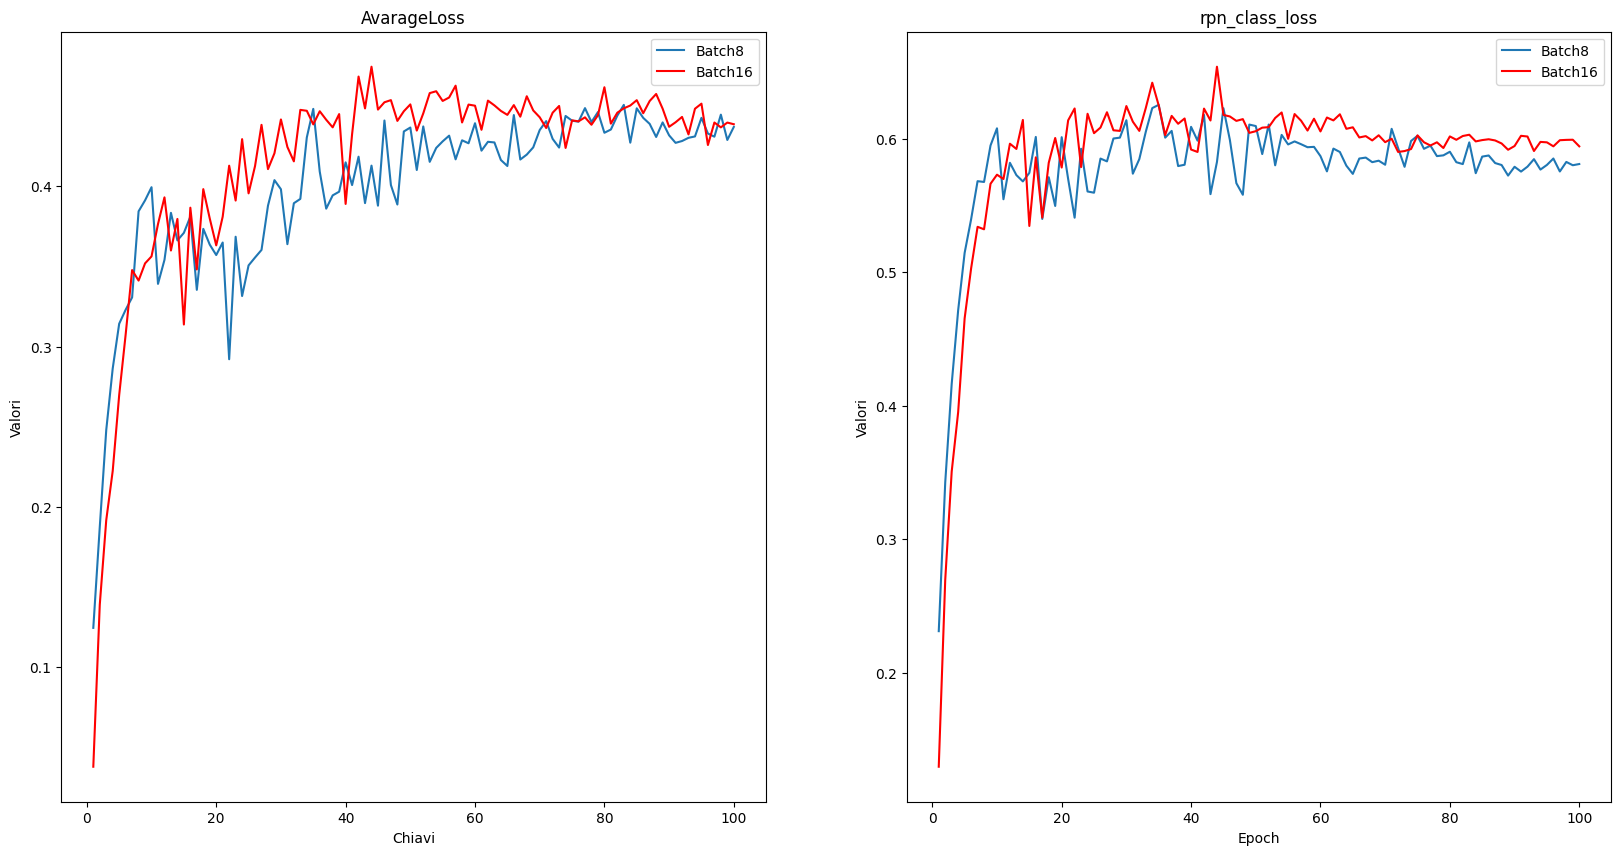

In [44]:
with open('EsecuzioneBatch8/MetricheBBox.json', 'r') as file_json:
    # Carica il contenuto del file JSON
    mApBBox8 = json.load(file_json)

with open('EsecuzioneBatch8/MetricheSegm.json', 'r') as file_json:
    # Carica il contenuto del file JSON
    mApSeg8 = json.load(file_json)

with open('EsecuzioneBatch16/MetricheBBox.json', 'r') as file_json:
# Carica il contenuto del file JSON
    mApBBox16= json.load(file_json)

with open('EsecuzioneBatch16/MetricheSegm.json', 'r') as file_json:
    # Carica il contenuto del file JSON
    mApSeg16 = json.load(file_json)

mApBBox8List=[]
mApBBox16List=[]
mApSeg8List=[]
mApSeg16List=[]

for i in range(len(avgLoss16)+1):
    if(i>0):
        mApSeg16List.append(mApSeg16[f'{i}']['mAP50'])
        mApBBox16List.append(mApBBox16[f'{i}']['mAP50'])
        mApSeg8List.append(mApSeg8[f'{i}']['mAP50'])
        mApBBox8List.append(mApBBox8[f'{i}']['mAP50'])

plt.figure(figsize=(20, 10))  # Larghezza x Altezza in pollici


plt.subplot(1, 2, 1)  # 1 riga, 2 colonne, primo grafico
plt.plot(epochs, mApSeg8List, linestyle='-',label='Batch8')
plt.plot(epochs, mApSeg16List, linestyle='-',color='red', label='Batch16')
plt.xlabel('Chiavi')
plt.ylabel('Valori')
plt.title('AvarageLoss')
plt.legend()

plt.subplot(1, 2, 2)  # 1 riga, 2 colonne, secondo grafico
plt.plot(epochs, mApBBox8List, linestyle='-',label='Batch8')
plt.plot(epochs, mApBBox16List, linestyle='-',color='red', label='Batch16')
plt.xlabel('Epoch')
plt.ylabel('Valori')
plt.title('rpn_class_loss')
plt.legend()


Osservando la variazione della loss nel tempo, è possibile effettuare alcune considerazioni:
- Nelle prime epoche, si osserva una **decrescita rapida** della loss, indicando che il modello sta apprendendo e migliorando la sua capacità di adattarsi ai dati di addestramento.
- Dopo un certo numero di epoche, la decrescita della loss sembra **stabilizzarsi**. Questo potrebbe indicare che il modello ha raggiunto un livello di apprendimento in cui la sua performance non migliora significativamente.
- Alcuni punti mostrano un **aumento temporaneo** della loss.
- Il valore più basso della loss si trova all'epoca 50, indicando che a quel punto il modello ha raggiunto la sua **miglior performance** in termini di adattamento ai dati di addestramento.

#### **Visualizzazione delle Predizioni del Modello: Esempio di Output**



In [ ]:
def getImageFromId(imgName):
    for image in test_dataloader:
        if image[1][0]['id']==imgName:
            return image[0][0].unsqueeze(0)

    return 0

model.eval()
netInput= getImageFromId(25)
output=model(netInput.to(device))

classes = output[0]['labels']
scores = output[0]['scores']
boxes = output[0]['boxes']
masks = output[0]['masks']

boxes = boxes.view(-1, 4)
masks = masks.view(-1, 700, 700)

threshold=0.3
boxes = boxes.cpu()
masks=masks.cpu()

imageFinal=netInput.squeeze().cpu().numpy()

patchesList=[]
finalMask=0

#Per ogni maschera
for i in range(masks.shape[0]):
  bbox=boxes[i].detach().numpy()
  rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
  patchesList.append(rect)

  maskT=masks[i].detach().numpy()

  maskT[maskT>threshold]=1
  maskT[maskT<=threshold]=0

  finalMask+=maskT


for i in range(len(finalMask)):
  for j in range(len(finalMask[0])):
    if(finalMask[i][j]==1):
      imageFinal[0][i][j]=0
      imageFinal[0][i][j]=143
      imageFinal[0][i][j]=57

imageFinal=np.transpose(imageFinal, (1, 2, 0))

test_dir="Dataset/testset"

# Carica il file JSON di addestramento
test_json_path = os.path.join(test_dir, "test.json")
coco_test = COCO(test_json_path)


# Load information about the selected image
img_info = coco_test.loadImgs(25)[0]
imageGT= getImageFromPath(25).squeeze().numpy()

# Get annotations for the selected image
ann_ids = coco_test.getAnnIds(imgIds=img_info['id'])
annotations = coco_test.loadAnns(ann_ids)

patchImageGT=[]

# Display each segmentation mask along with the bounding box
for ann in annotations:
    mask += coco_test.annToMask(ann)
    bbox = ann['bbox']
    bbox = [int(coord) for coord in bbox]
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
    patchImageGT.append(rect)

for i in range(len(mask)):
  for j in range(len(mask[0])):
    if(mask[i][j]==1):
      imageGT[0][i][j]=0
      imageGT[0][i][j]=143
      imageGT[0][i][j]=57

imageGT=np.transpose(imageGT, (1, 2, 0))

fig, ax =plt.subplots(1, 2, figsize=(30, 20))

ax[0].imshow(imageFinal)
ax[0].set_title('Output Modello')

ax[1].imshow(imageGT)
ax[1].set_title('Ground Truth')

for patch in patchesList:
    newPatch=copy(patch)
    ax[0].add_patch(newPatch)

for patch in patchImageGT:
    newPatch=copy(patch)
    ax[1].add_patch(newPatch)

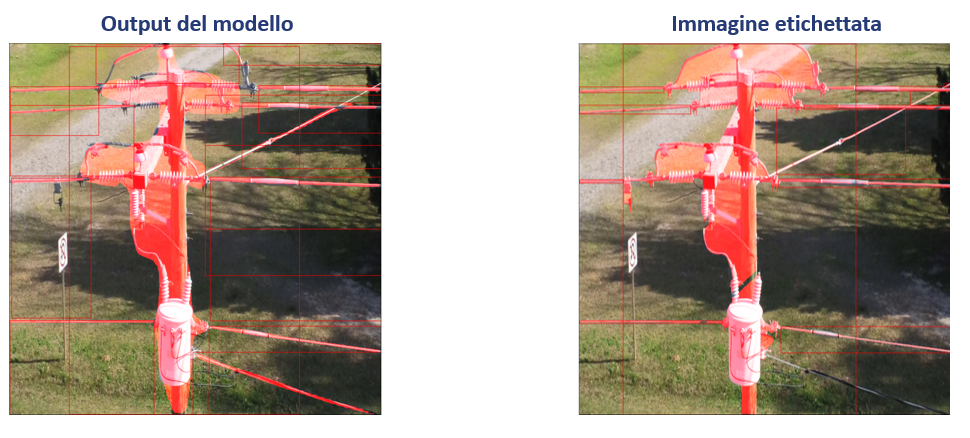